In [1]:
# plan

# - caclulate monthly Q for different land covers 
# - calculate how on average change in lang cover affect the change in runoff -> transport capacity -> TL case 



# plan
# 1 - calculate the monthly water yeild 
# 2 - plot average + spread per month 


In [2]:
import pandas as pd 
import xarray as xr
import matplotlib.pyplot as plt 
import numpy as np
import os
import seaborn as sns


import functions



# calculate the monthly values in mm 

In [3]:
def water_balance_components_in_mm(hydro, column, area=4830.0):
    """
    Calculate the sum of water or sediment volume per month for a specific column, 
    and return the mean volumes across years.
    
    Parameters:
    hydro (pd.DataFrame): Input DataFrame with columns `D` (date) and the specified numeric column.
    column (str): The name of the column to calculate the volume for.
    area (float): Area in square meters used to scale the volumes. Default is 4830.0.
    
    Returns:
    pd.DataFrame: DataFrame with the calculated monthly volumes.
    """
    # Ensure `D` column is in datetime format
    hydro['D'] = pd.to_datetime(hydro['D'])

    if column == 'snowmelt':
        hydro['snowmelt'] = hydro['snowacc'].where(hydro['snowacc'] < 0).fillna(0)
    if column == 'snowacc2':
        hydro['snowacc2'] = hydro['snowacc'].where(hydro['snowacc'] > 0).fillna(0)
    if column == 'rainfall':
        hydro['rainfall'] = hydro['Pr'] - hydro['snowacc']
        hydro['rainfall'] = hydro['rainfall'].fillna(0)
        
    
    # Scale the specified column by the area
    hydro[column] = hydro[[column]]
    
    # Set 'D' as the index
    hydro = hydro.set_index('D')
    
    # Resample to monthly data and calculate the sum for each month for the specified column
    hydro_month = hydro[column].resample('M').sum().reset_index()
    
    # Extract year and month for grouping or further analysis
    hydro_month['year'] = hydro_month['D'].dt.year
    hydro_month['month'] = hydro_month['D'].dt.month
    
    return hydro_month


In [4]:
# folders = '/Volumes/6382452/!Feb2024/paper2/model_runs/TL_data/1landcover/langtang_climate_cut'

In [11]:
%%time

# column = 'Pr'  # Set the target column
location = 'langtang'

if location == 'langtang':
    folder_loc = '12a'
if location == 'mustang': 
    folder_loc = '13a'



# landcover1_folder = f'/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/TL_data/1landcover/{location}_climate_cut'
# landcover2_folder = f'/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/TL_data/2landcover/{location}_climate_cut'
# landcover3_folder = f'/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/TL_data/1landcover/{location}_climate_cut'
# landcover4_folder = f'/Volumes/Extreme SSD/202409_paper2_modelruns/30years/SL_daily/1landcover_40percent/{location}_climate_cut' #this one is different - no change in glacier 
# landcover5_folder = f'/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/TL_data/5landcover/{location}_climate_cut'





output_path = '/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/output/hydro'

# Define the list of folder paths

folder_paths = [f'/Volumes/Extreme SSD/202409_paper2_modelruns/30years/SL_daily/1landcover_30percent/{location}_climate_cut',
                f'/Volumes/Extreme SSD/202409_paper2_modelruns/30years/SL_daily/2landcover_30percent/{location}_climate_cut',
                f'/Volumes/Extreme SSD/202409_paper2_modelruns/30years/SL_daily/3landcover_30percent/{location}_climate_cut',
                f'/Volumes/Extreme SSD/202409_paper2_modelruns/30years/SL_daily/4landcover_30percent/{location}_climate_cut',
                f'/Volumes/Extreme SSD/202409_paper2_modelruns/30years/SL_daily/5landcover_30percent/{location}_climate_cut']





# Load elevation data and define the output path
elevation = pd.read_csv(f'/Users/varyabazilova/Desktop/paper2/downscaling_simple/coordinates_and_elevation_with_labels_{location}.csv')[['cellnr2', 'band_data']]
elevation = elevation.transpose()
elevation_list = elevation.loc['cellnr2'].tolist() 


CPU times: user 10.9 ms, sys: 3.36 ms, total: 14.3 ms
Wall time: 12.1 ms


In [12]:
# loop over columns too 
columns = ['PET', 'AET', 'Q', 'snowacc2', 'snowmelt', 'glacier_melt', 'Pr', 'rainfall']

In [13]:
print(columns)  # Ensure `columns` is defined as a list of column names

# Iterate over columns
for column in columns:
    print(f"Processing column: {column}")

    # Iterate over folder paths
    for folder_path in folder_paths:
        print(f"Processing folder: {folder_path}")

        output_folder = output_path

        # Extract "1landcover" from the folder path
        landcover_part = os.path.basename(os.path.dirname(folder_path))
        landcover_base = landcover_part.split('_')[0]  # This gives "1landcover"

        # Load timestep DataFrame (assuming Hydro.out exists in the `/12a/` subfolder for all folders)
        hydro_path = os.path.join(folder_path, folder_loc, 'Hydro.out')
        print(f"Checking Hydro.out path: {hydro_path}")

        if not os.path.isfile(hydro_path):
            print(f"Hydro.out not found in {hydro_path}")
            continue  # Skip this folder_path if the main Hydro.out is missing

        # Load the Hydro.out file for timestep calculation
        try:
            dfts = pd.read_csv(hydro_path)
            df = water_balance_components_in_mm(dfts, column, area=4830.0)
            df = df[['month', 'year']]
        except Exception as e:
            print(f"Error loading timestep file: {e}")
            continue

        # Initialize the result DataFrame for this folder_path
        result_df = pd.DataFrame()

        # Iterate over subfolders in the folder path
        for folder_name in os.listdir(folder_path):
            subfolder_path = os.path.join(folder_path, folder_name)
            
            # Skip files and hidden folders
            if not os.path.isdir(subfolder_path) or folder_name.startswith('.'):
                continue

            file_path = os.path.join(subfolder_path, 'Hydro.out')
            # print(f"Checking subfolder Hydro.out: {file_path}")

            # Ensure the Hydro.out file exists in the subfolder
            if os.path.isfile(file_path):
                try:
                    hydro = pd.read_csv(file_path)
                    output_df = water_balance_components_in_mm(hydro, column)

                    # Extract and rename the target column
                    name_column = output_df[column]
                    column_name = f'{column}_{folder_name}'
                    result_df[column_name] = name_column
                except Exception as e:
                    print(f"Error processing file {file_path}: {e}")
                    continue

        # Ensure result_df has data before proceeding
        if result_df.empty:
            print(f"No valid data found in subfolders of {folder_path}")
            continue

        # Rename columns for clarity and filter by elevation list
        result_df.columns = [col[-3:] for col in result_df.columns]  # Adjust column names if necessary
        result_df = result_df[elevation_list]

        # Check for consistency with the elevation list
        if elevation_list == result_df.columns.tolist():
            print("Default land cover. Monthly data: same")

            # Rename columns, merge with timestep, and add folder info
            result_df.columns = elevation.loc['band_data']
            result_df = pd.concat([df, result_df], axis=1)
            result_df['folder'] = os.path.basename(folder_path)

            print(result_df)

            # Define the output file name and save the DataFrame to a CSV file
            output_filename = f'{location}_monthly_sum_elevation_{column}_{landcover_base}_mm.csv'
            print('output filename:', output_filename)
            result_df.to_csv(os.path.join(output_folder, output_filename), index=False)

            print(f"Saved {output_filename}")
        else:
            print(f"The data does not match the elevation list for {folder_path}!")


['PET', 'AET', 'Q', 'snowacc2', 'snowmelt', 'glacier_melt', 'Pr', 'rainfall']
Processing column: PET
Processing folder: /Volumes/Extreme SSD/202409_paper2_modelruns/30years/SL_daily/1landcover_30percent/langtang_climate_cut
Checking Hydro.out path: /Volumes/Extreme SSD/202409_paper2_modelruns/30years/SL_daily/1landcover_30percent/langtang_climate_cut/12a/Hydro.out
Default land cover. Monthly data: same
     month  year     4485.0      3734.0     4880.0     4847.0      3908.0  \
0        9  1989  78.753278   90.808870  53.246150  56.237134   91.026111   
1       10  1989  87.027578  116.530330  52.002470  52.443126  114.720610   
2       11  1989  36.722167   64.293090  32.709323  33.038585   61.463686   
3       12  1989  30.511118   37.809883  26.896797  27.191480   37.248736   
4        1  1990  36.011790   55.549667  32.097935  32.419307   49.517326   
..     ...   ...        ...         ...        ...        ...         ...   
392      5  2022  71.849428  144.457013  65.388368  65.

# plots! - water balance components 

In [14]:
# plot of interest: 
# barplots with + and - components 
# components:
# AET PET Q GLACIER_MELT SNOW_MELT SNOW_ACC 

# + Pr, snow melt, glacier melt
# - AET PET Q 


def prepare_for_boxplots(df, value_name):
    # value name - column in the output dataframe
    melted = pd.melt(df, id_vars=['month','folder', 'year'], var_name='elevation', value_name=value_name)
    melted['elevation'] = melted['elevation'].str.split('.').str[0].astype(float)
    melted['elevation_bin'] = melted.apply(functions.bin_elevation500, axis=1)
    melted = melted.sort_values('elevation_bin')
    return melted

In [101]:
# test for landcover 1
landcover_idx = 5
location = 'langtang' # 'mustang'

folder = '/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/output/hydro/'

aet1      = pd.read_csv(folder + f'{location}_monthly_sum_elevation_AET_{landcover_idx}landcover_mm.csv')
pet1      = pd.read_csv(folder + f'{location}_monthly_sum_elevation_PET_{landcover_idx}landcover_mm.csv')
Q1        = pd.read_csv(folder + f'{location}_monthly_sum_elevation_Q_{landcover_idx}landcover_mm.csv')
glmelt1   = pd.read_csv(folder + f'{location}_monthly_sum_elevation_glacier_melt_{landcover_idx}landcover_mm.csv')
snowmelt1 = pd.read_csv(folder + f'{location}_monthly_sum_elevation_snowmelt_{landcover_idx}landcover_mm.csv')
pr1       = pd.read_csv(folder + f'{location}_monthly_sum_elevation_Pr_{landcover_idx}landcover_mm.csv')
snowacc1  = pd.read_csv(folder + f'{location}_monthly_sum_elevation_snowacc2_{landcover_idx}landcover_mm.csv')
rainfall1 = pd.read_csv(folder + f'{location}_monthly_sum_elevation_rainfall_{landcover_idx}landcover_mm.csv')






In [102]:
aet1_melted = prepare_for_boxplots(aet1, 'AET')
pet1_melted = prepare_for_boxplots(pet1, 'PET')
Q1_melted = prepare_for_boxplots(Q1, 'Q')

glmelt1_melted = prepare_for_boxplots(glmelt1, 'glmelt')
snowmelt1_melted = prepare_for_boxplots(snowmelt1, 'snowmelt')
pr1_melted = prepare_for_boxplots(pr1, 'Pr')
snowacc1_melted = prepare_for_boxplots(snowacc1, 'snowacc')


# make snowmelt not negative 
snowmelt1_melted['snowmelt'] = snowmelt1_melted['snowmelt'] * -1


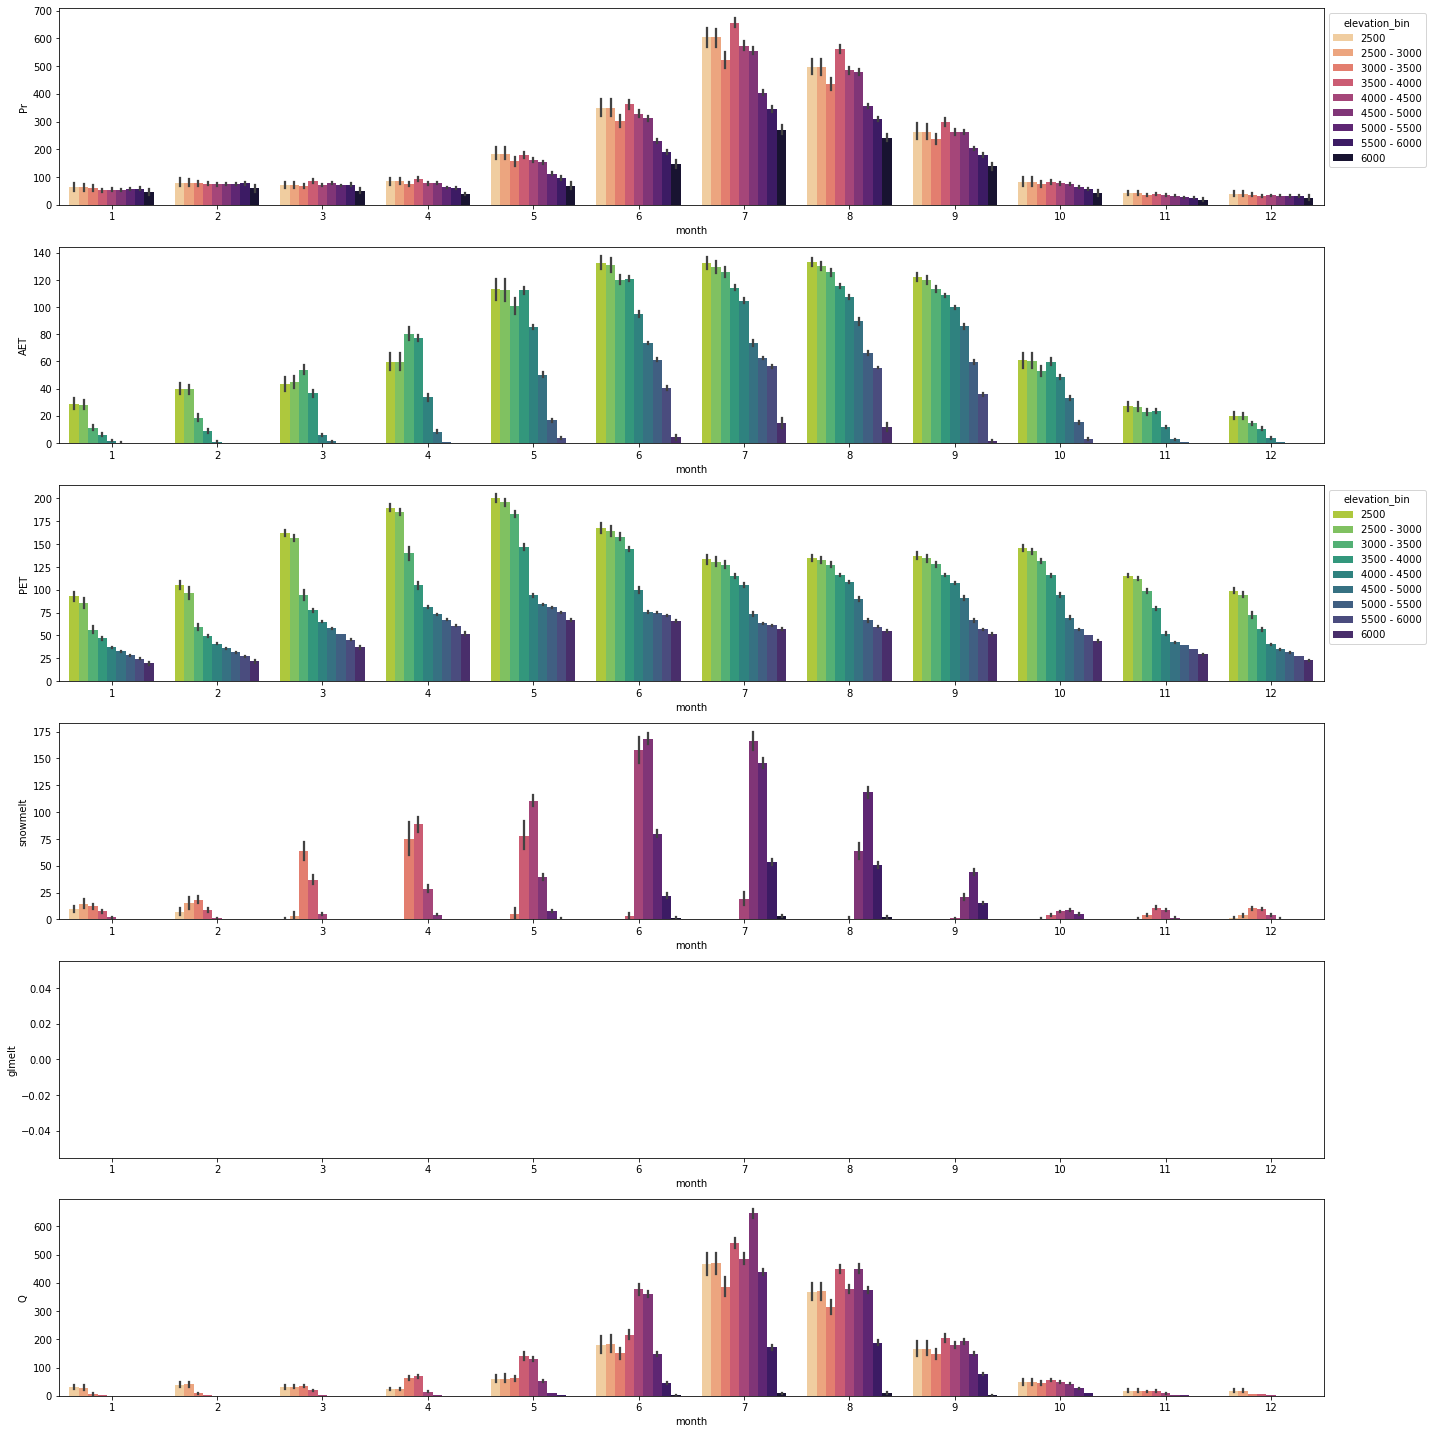

In [103]:
fig = plt.figure(figsize=(20, 20), layout = 'tight')
mosaic = fig.subplot_mosaic('''
                            aaa
                            bbb
                            ccc
                            eee
                            fff
                            ggg
                            ''')


sns.barplot(ax = mosaic['a'], x='month', y='Pr', hue = 'elevation_bin', data=pr1_melted, palette = 'magma_r', legend = True) 
sns.barplot(ax = mosaic['b'], x='month', y='AET', hue = 'elevation_bin', data=aet1_melted, palette = 'viridis_r', legend = False) 
sns.barplot(ax = mosaic['c'], x='month', y='PET', hue = 'elevation_bin', data=pet1_melted, palette = 'viridis_r', legend = True)
# sns.barplot(ax = mosaic['d'], x='month', y='snowacc', hue = 'elevation_bin', data=snowacc1_melted, palette = 'magma_r', legend = False)
sns.barplot(ax = mosaic['e'], x='month', y='snowmelt', hue = 'elevation_bin', data=snowmelt1_melted, palette = 'magma_r', legend = False)
sns.barplot(ax = mosaic['f'], x='month', y='glmelt', hue = 'elevation_bin', data=glmelt1_melted, palette = 'magma_r', legend = False)
sns.barplot(ax = mosaic['g'], x='month', y='Q', hue = 'elevation_bin', data=Q1_melted, palette = 'magma_r', legend = False)


sns.move_legend(mosaic['a'], "upper left", bbox_to_anchor=(1, 1))
sns.move_legend(mosaic['c'], "upper left", bbox_to_anchor=(1, 1))

# # Adding text to the top-left corner of each subplot
# mosaic['a'].text(0.02, 0.95, 'veg 40%, bedrock 40%, ice 20%', transform=mosaic['a'].transAxes, fontsize=25, verticalalignment='top')
# mosaic['b'].text(0.02, 0.95, 'veg 40%, bedrock 50%, ice 10%', transform=mosaic['b'].transAxes, fontsize=25, verticalalignment='top')
# mosaic['c'].text(0.02, 0.95, 'veg 50%, bedrock 40%, ice 10%', transform=mosaic['c'].transAxes, fontsize=25, verticalalignment='top')
# mosaic['d'].text(0.02, 0.95, 'veg 40%, bedrock 60%, ice 0%',  transform=mosaic['d'].transAxes, fontsize=25, verticalalignment='top')





if landcover_idx ==1:
    plt.suptitle('veg 40%, bedrock 40%, ice 20%', fontsize = 25)
if landcover_idx ==2:
    plt.suptitle('veg 40%, bedrock 50%, ice 10%', fontsize = 25)
if landcover_idx ==3:
    plt.suptitle('veg 50%, bedrock 40%, ice 10%', fontsize = 25)



In [104]:
# List of components (example structure)
wb_components = [aet1_melted, pet1_melted, Q1_melted, glmelt1_melted, snowmelt1_melted, 
                 pr1_melted, snowacc1_melted, snowmelt1_melted]


grouped_dfs = []

# Iterate over each component, group by 'month', and compute the mean
for c in wb_components:
    grouped = c.groupby('month').mean().drop(columns=['elevation', 'year'])
    # Add a suffix to the column names to indicate the source DataFrame
    grouped = grouped.add_suffix(f'_lc{landcover_idx}')
    grouped_dfs.append(grouped)

# Concatenate all grouped DataFrames along the columns
result_df = pd.concat(grouped_dfs, axis=1)

# result_df.to_csv(folder + f'wb_components_monthly_mean_{location}_landcover{landcover_idx}.csv')

<AxesSubplot:xlabel='month'>

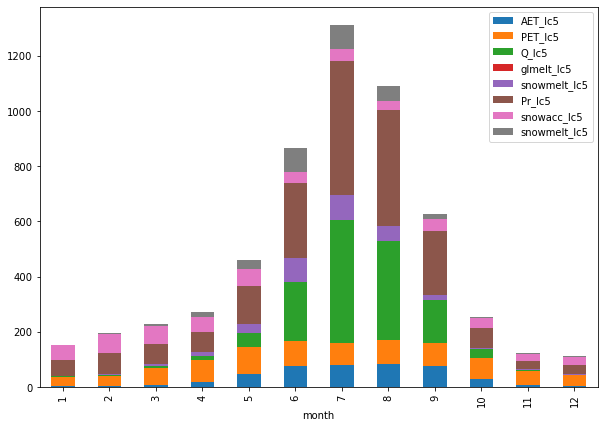

In [105]:
result_df.plot(kind = 'bar', stacked = True, figsize=(10, 7))

In [ ]:
# in componetns 
# 

In [ ]:
glmelt1 = pd.read_csv(f'/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/hydro/langtang_monthly_sum_elevation_glacier_melt_{landcover_idx}landcover_mm.csv')
glmelt1

In [ ]:
plt.figure(figsize=(20, 20), layout = 'tight')

glmelt1.set_index(['year', 'month']).plot()

In [ ]:
testfile = pd.read_csv('/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/TL_data/1landcover/langtang_climate_cut/12a/Hydro.out')
testfile

In [ ]:
plt.figure(figsize=(10, 5), layout = 'tight')
testfile[1:10000].glacier_melt.plot(label = 'glacier')
testfile[1:10000].Pr.plot(label = 'Pr')
testfile[1:10000].Ta.plot(label = 'Ta')
plt.legend()